# Examine changes in viable habitat

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import shutil
from itertools import product
import json
import yaml
import intake
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import funnel
import data_collections as dc
import operators as ops
import util

import metabolic as mi

In [4]:
curator = util.curator_local_assets()
cat = curator.open_catalog()  
ds_ts = cat['trait-space'].to_dask().load()
trait_spc_wgt = ds_ts.trait_spc_wgt

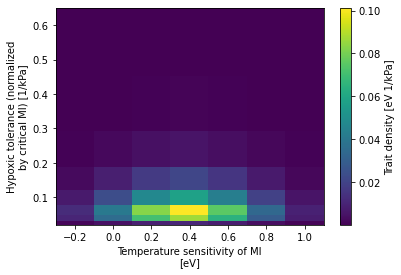

In [5]:
trait_spc_wgt.plot();

In [6]:
dEodT_bar = mi.dEodT_bar
dEodT_bar

-0.0226

In [11]:
catalog_json_file = funnel.to_intake_esm(agg_member_id=True)

sub_spec = dict(
    name='drift-corrected',
    experiment=['20C', 'RCP85'],
    member_id=dc.ocean_bgc_member_ids[1:],
)

catalog = funnel.to_intake_esm(agg_member_id=True).search(**sub_spec)
catalog

,unique
experiment,2
component,1
stream,1
member_id,33
variable,8
name,1
path,1675
Ac,6
Eo,6
dEodT,1


In [12]:
catalog.search(experiment='20C', variable=['pO2', 'TEMP'], member_id=10).df

,experiment,component,stream,member_id,variable,name,path,Ac,Eo,dEodT
0,20C,ocn,pop.h,10,TEMP,drift-corrected,/glade/scratch/mclong/ocean-metabolism/funnel-...,NaN,NaN,NaN
1,20C,ocn,pop.h,10,pO2,drift-corrected,/glade/scratch/mclong/ocean-metabolism/funnel-...,NaN,NaN,NaN


In [13]:
cache_dir = '/glade/scratch/mclong/ocean-metabolism/funnel-cache'

def _gen_cache_file_name(experiment, component, stream, member_id, variable):
    return f'{cache_dir}/glade-cesm1-le.{experiment}.{component}.{stream}.{int(member_id):03d}.{variable}.drift-corrected.zarr'


def _make_cache(experiment, component, stream, member_id, variable):
    """
    Manually generate funnel catalog entry
    
    I.e.:
    asset: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.101.TEMP.drift-corrected.zarr
    esm_collection: data/catalogs/glade-cesm1-le.json
    key: 20C.ocn.pop.h.101
    name: drift-corrected
    operator_kwargs:
    - {}
    - {}
    - {}
    operators:
    - compute_time
    - sel_time_slice
    - compute_drift_correction
    preprocess: _preprocess_pop_h_upper_1km
    variable: TEMP
    """
    
    cache_id_dict = dict(
        asset=_gen_cache_file_name(experiment, component, stream, member_id, variable),
        esm_collection='data/catalogs/glade-cesm1-le.json',        
        key=f'{experiment}.{component}.{stream}.{member_id}',
        name='drift-corrected',
        operator_kwargs=[{}, {}, {}],
        operators=['compute_time', 'sel_time_slice', 'compute_drift_correction'],
        preprocess='_preprocess_pop_h_upper_1km',
        variable=variable,
    )
    cache_id_file = f'data/funnel-catalog/glade-cesm1-le.{experiment}.{component}.{stream}.{int(member_id):03d}.{variable}.drift-corrected.yml'
    with open(cache_id_file, 'w') as fid:
        yaml.dump(cache_id_dict, fid)    
        

In [14]:
try:
    cluster
    client
except:
    cluster, client = util.get_ClusterClient(memory='100GB')
    cluster.scale(34)
client    

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.55:34145,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [15]:
# refresh catalog
catalog = funnel.to_intake_esm(agg_member_id=False).search(**sub_spec)
experiment_list = sorted(catalog.unique('experiment')['experiment']['values'])
member_id_list = sorted(catalog.unique('member_id')['member_id']['values'])

In [17]:
clobber = False

stream = 'pop.h'
component = 'ocn'
    
variable = 'depth_habitat_trait_wgt'

for experiment, member_id in product(experiment_list, member_id_list):

    # check for existing cache file
    asset = _gen_cache_file_name(experiment, component, stream, member_id, variable)

    if clobber and os.path.exists(asset):
        print(f'removing: {asset}')
        shutil.rmtree(asset)

    if os.path.exists(asset):
        print(f'exists: {asset}')
        continue    

    with util.timer(f'{experiment}.{member_id}'):
    
        cat = catalog.search(
            experiment=experiment, 
            member_id=member_id, 
            stream=stream, 
            component=component,
            variable=['TEMP', 'pO2'],
        )

        # ensure variables
        missing_vars = {'TEMP', 'pO2'} - set(cat.df.variable.to_list())
        if missing_vars:
            print(f'missing vars for {experiment}.{member_id:03d}: {missing_vars}')
            continue

        dset = cat.to_dataset_dict()
        assert len(dset.keys()) == 1    
        _, ds = dset.popitem()

        # compute 
        print(f'computing: {asset}')

        # compute trait-density weighted sum of viable habitat over depth
        var_out = xr.full_like(ds.TEMP[:, 0, :, :], fill_value=0.)        
        dso = ds[['TAREA', 'KMT', 'TLONG', 'TLAT', 'KMT', 'z_t', 'dz']]
        for Eo, Ac in product(Eo_coord.values, Ac_coord.values):
            # get the trait weighting for this trait
            trait_wgt_ij = trait_spc_wgt.sel(Eo=Eo, Ac=Ac).values
            
            # compute the metabolic index
            Phi = mi.Phi(ds.pO2, ds.TEMP, Ac, Eo, dEodT=dEodT_bar)
                        
            # compute the vertical integral of habitat volume where Φ > 1
            # multiplied by trait space weighting            
            viable_trait_mask = xr.where(Phi > 1, trait_wgt_ij, 0.0) 
            
            # add this "viable depth" to total depth
            var_out += (ds.dz * viable_trait_mask).sum('z_t')
            
        print(f'writing: {asset}')
        var_out.name = variable
        var_out.attrs['long_name'] = 'Trait-space weighted vertical habitat'
        var_out.attrs['units'] = ' '.join([ds.z_t.attrs['units'], units_trait_spc])
        dso[variable] = var_out
        dso.to_zarr(asset, mode='w', consolidated=True)    
        _make_cache(experiment, component, stream, member_id, variable)


exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.depth_habitat_trait_wgt.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.depth_habitat_trait_wgt.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.depth_habitat_trait_wgt.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.depth_habitat_trait_wgt.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.depth_habitat_trait_wgt.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.depth_habitat_trait_wgt.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.depth_habitat_trait_wgt.drift-corrected.zarr
exists: /glade/scratch/mclong/ocea